## Импортируем библиотеки

In [ ]:
!pip install sklearn_crfsuite

In [ ]:
import copy
import pickle
import sys

from string import punctuation

import pandas as pd

In [ ]:
import sklearn_crfsuite

import matplotlib.pyplot as plt

## Предобработка и лейблы (то, что раньше было в другой тетрадке)

In [ ]:
#punctuation += ' …' #c этой штукой почему-то всё отвалилось из-за кодировки
punctuation += ' '
sep='>'

### Записываем алфавит киче в удобном виде

In [ ]:
kiche_anbur = "a [a], ä [ə], e [ɛ], i [i], o [o], u [u], m [m], n [n], nh [ŋ], p [p], bʼ [ɓ], t [t], tʼ [tʼ], k [k], kʼ [kʼ], q [q], qʼ [qʼ], tz [ʦ], tzʼ [ʦ’], ch [ʧ], chʼ [ʧ’], s [s], x [ʃ], j [χ], h [h], r [r], l [l], y [j], w [w], ʼ [ʔ]"
alphabet = []
for letter in kiche_anbur.split(","):
    letter = letter.split()[0]
    alphabet.append(letter)
    alphabet.append(letter[0].upper() + letter[1:])

In [ ]:
alph_to_int = dict(zip(alphabet, range(len(alphabet))))
int_to_alph = dict(zip(range(len(alphabet)), alphabet))

### Функции для токенизации, побуквенная и посимвольная


In [ ]:
def window(text, size):
    tokens = []
    i = 0
    while i < (len(text)-size+1):
        try:
            current = ''.join(text[i:i+size])
        except:
            current = 'not_in_alphabet'
        if current in alphabet:
            tokens.append(alph_to_int[current])
            i += size
        else:
            tokens.append(text[i])
            i += 1
    return tokens

def tokenize_letters(text):
    tokens = list(text + 'ggg')
    for i in range(3, 0, -1):
        tokens = window(tokens, i)
    tokens_2 = []
    for token in tokens:
        if token in int_to_alph:
            token = int_to_alph[token]
        tokens_2.append(token)
    return tokens_2

In [ ]:
def tokenize_symbols(text):
    #return(list(text))
    tokens = []
    for s in text:
      tokens.append(s)
    return tokens

In [ ]:
def tokenize(text, type_='letters'):
  if type_ == 'letters':
    return tokenize_letters(text)
  if type_ == 'symbols':
    return tokenize_symbols(text)

Функция, которая навешивает лейблы

In [ ]:
#sep — c разделителем, not — без разделителя
#b, m и s значат beginning, middle и end, а s — single
def to_labels(tokens, unite_punct=False):
    border_tokens = sep + punctuation
    labels = []
    tokens = [sep] + tokens + [sep]
    for i in range(1, len(tokens)-1):
        current = tokens[i]
        previous = tokens[i-1]
        next_ = tokens[i+1]
        if current != sep:
            if current not in punctuation:
                if previous in border_tokens:
                    if next_ in border_tokens:
                        labels.append('s-morph') #labels.append('sep')
                    else:
                        labels.append('b-morph') #labels.append('not')
                elif next_ in border_tokens:
                    labels.append('e-morph') #labels.append('sep')
                else:
                    labels.append('m-morph') #labels.append('not')
            else:
                if not unite_punct:
                  labels.append(current)
                else:
                  labels.append('punct')
    return labels

### Функция, которая открывает файл .tsv и создаёт колонки с токенизацией и лейблами

In [ ]:
def preprocess_df(df, text='text', with_sep='with_sep', unite_punct=False, type_='letters'):
    df['tokens_with_sep'] = df[with_sep].apply(lambda x: tokenize(x, type_))
    df['tokens'] = df['tokens_with_sep'].apply(lambda array: list(filter(lambda x: x!=sep, array)))
    df['tokens_honest'] = df[text].apply(lambda x: tokenize(x, type_))
    df['labels'] = df['tokens_with_sep'].apply(lambda x: to_labels(x, unite_punct))


def open_and_preprocess(filename, text='text', with_sep='with_sep', unite_punct=False, type_='letters'):
  df = pd.read_csv(filename, sep='\t', names=[text, with_sep], encoding='utf-8')
  preprocess_df(df, text, with_sep, unite_punct, type_)
  return df

## Функции, которые добавляют свойства и делают из токена словарь свойств

### Свойства

In [ ]:
def is_vowel(token):
  return token.lower() in 'aeiouä'

In [ ]:
def vow_cons(token, document=None, i=None):
  if token in punctuation:
    return 'none'
  elif is_vowel(token):
    return 'v'
  else:
    return 'c'

In [ ]:
# begin, middle, end и single
def position(token, document, i):
  if token in punctuation:
    return 'none'
  elif i == 0:
    return 'b'
  elif i == len(document) - 1:
    return 'e'
  elif document[i-1] == ' ' and document[i+1] == ' ':
    return 's'
  elif document[i-1] == ' ':
    return 'b'
  elif document[i+1] == ' ':
    return 'e'
  else:
    return 'm'

In [ ]:
def lower(token, document=None, i=None):
  return token.lower()

In [ ]:
def is_upper(token, document=None, i=None):
  return token[0].isupper()

In [ ]:
def trigramma(token, document, i):
  token = token.lower()
  if i != 0:
    previous = document[i-1].lower()
  else:
    previous = ''
  if i != len(document) - 1:
    next_ = document[i+1].lower()
  else:
    next_ = ''
  return previous + token + next_

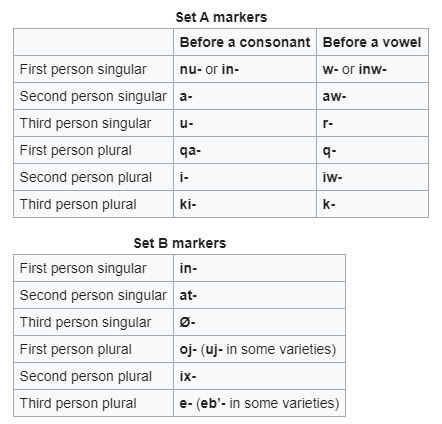

In [ ]:
def my_str(array):
  return ''.join(array).lower() #почему-то если не писать тут lower, то скор только с set_a становится больше

In [ ]:
def set_a(token, document, i):
  if i != len(document)-1:
    markers_cons = ['nu', 'in', 'qa', 'ki']
    markers_vowel = ['inw', 'aw', 'iw']
    morpheme = my_str(document[i-1:i+1])
    next_ = document[i+1]
    if is_vowel(next_):
      if morpheme in markers_vowel:
        return True
      if my_str(document[i-2:i+1]) in markers_vowel:
        return True
    else:
      if morpheme in markers_cons:
        return True
  return False

In [ ]:
def set_b(token, document, i):
  if i != len(document)-1:
    markers = ['in', 'at', 'oj', 'uj', 'ix', 'ebʼ'] #тут будем считать, что токенизация была по буквам
    morpheme = my_str(document[i-1:i+1])
    if morpheme in markers:
      return True
  return False

### Превращение токена в словарь свойств

In [ ]:
# список фичей
features = {'token' : lower,
            'is_upper' : is_upper,
            'vow_cons' : vow_cons,
            'position' : position,
            'trigramma' : trigramma,
            'set_A' : set_a,
            'set_B' : set_b
            }

In [ ]:
def document_to_features(document, features):
  list_of_features = []
  for i, token in enumerate(document):
    token_features = {}
    for feature_name in features:
      feature = features[feature_name]
      token_features[feature_name] = feature(token, document, i)
    list_of_features.append(token_features)
  return list_of_features

## Функция, которая делает из названия файла X и y (если есть) для алгоритма

In [ ]:
def tsv_to_samples(filename, features, is_train=False, tokens='tokens_honest', labels='labels', 
                   text='text', with_sep='with_sep', unite_punct=False, type_='letters'):
  df = open_and_preprocess(filename, text, with_sep, unite_punct, type_)
  if is_train:
    tokens = 'tokens'
    X = list(df[tokens].apply(lambda x:document_to_features(x, features)))
    y = list(df[labels])
    return (df, X, y)
  else:
    X = list(df[tokens].apply(lambda x:document_to_features(x, features)))
    return (df, X)

## Открываем тренировочную выборку

In [ ]:
df_train, X_train, y_train = tsv_to_samples("train.tsv", features, is_train=True)

In [ ]:
df_train

,text,with_sep,tokens_with_sep,tokens,tokens_honest,labels
0,Ri numam xkamik are taq kʼo jumuchʼ lajuj ujun...,Ri nu>mam x>kamik are taq kʼo jumuchʼ lajuj u>...,"[R, i, , n, u, >, m, a, m, , x, >, k, a, m, ...","[R, i, , n, u, m, a, m, , x, k, a, m, i, k, ...","[R, i, , n, u, m, a, m, , x, k, a, m, i, k, ...","[b-morph, e-morph, , b-morph, e-morph, b-morp..."
1,Nojel qʼij ri a Tiʼx kuyuqʼuj le taq awaj jela...,Nojel qʼij ri a Tiʼx k>u>yuqʼuj le taq awaj je...,"[N, o, j, e, l, , qʼ, i, j, , r, i, , a, ,...","[N, o, j, e, l, , qʼ, i, j, , r, i, , a, ,...","[N, o, j, e, l, , qʼ, i, j, , r, i, , a, ,...","[b-morph, m-morph, m-morph, m-morph, e-morph, ..."
2,Kateʼbʼin .,K>at>eʼ>bʼin .,"[K, >, a, t, >, e, ʼ, >, bʼ, i, n, , .]","[K, a, t, e, ʼ, bʼ, i, n, , .]","[K, a, t, e, ʼ, bʼ, i, n, , .]","[s-morph, b-morph, e-morph, b-morph, e-morph, ..."
3,Entonses are kʼwaʼ le kawaj kinbʼij pan in .,Entonses are kʼ>waʼ le k>aw>aj k>in>bʼij pan in .,"[E, n, t, o, n, s, e, s, , a, r, e, , kʼ, >,...","[E, n, t, o, n, s, e, s, , a, r, e, , kʼ, w,...","[E, n, t, o, n, s, e, s, , a, r, e, , kʼ, w,...","[b-morph, m-morph, m-morph, m-morph, m-morph, ..."
4,Nim raqan le cheʼ .,Nim r>aqan le cheʼ .,"[N, i, m, , r, >, a, q, a, n, , l, e, , ch,...","[N, i, m, , r, a, q, a, n, , l, e, , ch, e,...","[N, i, m, , r, a, q, a, n, , l, e, , ch, e,...","[b-morph, m-morph, e-morph, , s-morph, b-morp..."
...,...,...,...,...,...,...
1467,Xax rij mansaʼn .,Xax r>ij mansaʼn .,"[X, a, x, , r, >, i, j, , m, a, n, s, a, ʼ, ...","[X, a, x, , r, i, j, , m, a, n, s, a, ʼ, n, ...","[X, a, x, , r, i, j, , m, a, n, s, a, ʼ, n, ...","[b-morph, m-morph, e-morph, , s-morph, b-morp..."
1468,Man kʼo ta pwaq chech ri umuqubʼal .,Man kʼo ta pwaq ch>ech ri u>muqubʼal .,"[M, a, n, , kʼ, o, , t, a, , p, w, a, q, ,...","[M, a, n, , kʼ, o, , t, a, , p, w, a, q, ,...","[M, a, n, , kʼ, o, , t, a, , p, w, a, q, ,...","[b-morph, m-morph, e-morph, , b-morph, e-morp..."
1469,Rajawaxik kakʼaman chawe le utijik le lej .,Rajawaxik ka>kʼaman ch>aw>e le u>tij>ik le lej .,"[R, a, j, a, w, a, x, i, k, , k, a, >, kʼ, a,...","[R, a, j, a, w, a, x, i, k, , k, a, kʼ, a, m,...","[R, a, j, a, w, a, x, i, k, , k, a, kʼ, a, m,...","[b-morph, m-morph, m-morph, m-morph, m-morph, ..."
1470,Sipojinaq ri nupam .,Sipojinaq ri nu>pam .,"[S, i, p, o, j, i, n, a, q, , r, i, , n, u, ...","[S, i, p, o, j, i, n, a, q, , r, i, , n, u, ...","[S, i, p, o, j, i, n, a, q, , r, i, , n, u, ...","[b-morph, m-morph, m-morph, m-morph, m-morph, ..."


## Функция, которая предсказывает лейблы и считает скор 

### Функция, которая превращает предсказанные лейблы в текст

In [ ]:
def to_text(tokens, labels):
  sep = '>'
  #d = dict(zip(tokens, labels))
  answer = ''
  for i in range(len(tokens)-1):
    previous = tokens[i-1]
    token = tokens[i]
    next_ = tokens[i+1]
    label = labels[i] 
    #if label in ['b-morph'] and previous not in punctuation:
      #answer += sep
    answer += token
    if label in ['s-morph', 'e-morph'] and next_ not in punctuation:
    #if label in ['sep'] and next_ not in punctuation:
      answer += sep
  answer += tokens[-1]
  answer = answer.replace(sep+sep, sep)
  return answer

### Две функции для подсчёта скора (из evaluation.py Франа)

In [ ]:
def evaluate(ref, hyp):
	"""
		Takes two strings, a reference and an output from the system, e.g.
		  ref = ch>aw>e
		  hyp = ch>awe
		and produces the precision, recall and F-score, e.g.
		  P = 1/3 = 0.333
		  R = 1/2 = 0.5
		  F = 2.0 / ((1.0/0.333)+(1/0.5)) = 0.3997
	"""
	ref = ref.split('>')
	sys = hyp.split('>')
	res = copy.copy(sys)
	
	# Find out how many matches we got, this way we can check for matches
	# that are duplicated
	matched = 0
	for r in ref:
		if r in res:
			matched += 1
			res.remove(r)
	
	# If we got 0 matches then we can't calculate a score, return 0s
	if matched == 0:
		return (0.0, 0.0, 0.0)
	
	# Calculate precision and recall
	P = matched/len(ref)
	R = matched/len(sys)

	# Calculate F-score
	F = 2.0 / ((1.0/P)+(1.0/R))

	return (P, R, F)

In [ ]:
def scores(ref, tst):
    n_tokens = 0
    n_sents = 0

    ref_file = open(ref)
    ref_line = ref_file.readline().strip()
    tst_file = open(tst)
    tst_line = tst_file.readline().strip()

    Ps = []
    Rs = []
    Fs = []

    # Read the ref and test files line by line
    while ref_line and tst_line:
    #	print(ref_line, '|||', tst_line)	

      ref_row = ref_line.split('\t')
      tst_row = tst_line.split('\t')

      if ref_row[0] != tst_row[0]:
        print('ERROR: Ref and test files are misaligned:', file=sys.stderr)
        print(ref_row)
        print(tst_row)

      ref = ref_row[1].split(' ')
      hyp = tst_row[1].split(' ')

      # Collect the individual precision and recalls
      for (r, h) in zip(ref, hyp):
        (p, r, f) = evaluate(r, h)
        Ps.append(p)
        Rs.append(r)
        Fs.append(f)

      # Update the number of tokens and sentences
      n_tokens += len(ref)	
      n_sents += 1

      ref_line = ref_file.readline().strip()
      tst_line = tst_file.readline().strip()

    ref_file.close()
    tst_file.close()

#    print('%d sentences read, %d tokens' % (n_sents, n_tokens))
    # Average the precision and recall over the number of tokens

    precision = sum(Ps)/n_tokens
    recall = sum(Rs)/n_tokens
    f_measure = sum(Fs)/n_tokens
#    print('P:', precision)
#    print('R:', recall)
#    print('F:', f_measure)

    answer = {
        'precision' : precision,
        'recall' : recall,
        'f-measure' : f_measure}
    return answer

### Собственно функция, которая предсказывает лейблы и считает скор


In [ ]:
def predict_and_score(crf, df, X, name='dev'):
  #предсказываем
  y = crf.predict(X)
  df['predicted_labels'] = y
  #превращаем в лейблы
  df['output'] = df.apply(lambda row: to_text(row['tokens_honest'], row['predicted_labels']), axis=1)
  #записываем в tsv
  df_output = df[['text', 'output']]
  filename = name+'_'+'output.tsv'
  df_output.to_csv(filename, sep='\t', encoding='utf-8', header=False, index=False)
  #считаем скор
  ref = filename
  tst = name + '.tsv'
  return scores(ref, tst)



## Создаём алгоритм и обучаем его

Создаём

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='ap',
    max_iterations=100,
    #algorithm='lbfgs',
    #c1=0.2,
    #c2=0.1,
    #max_iterations=500,
    all_possible_transitions=False
)

Обучаем

In [ ]:
%%time
crf.fit(X_train, y_train)

CPU times: user 3.23 s, sys: 18.4 ms, total: 3.25 s
Wall time: 3.28 s


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='ap', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=None, c2=None, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

## Посчитаем скор для dev-выборки с дефолтными параметрами

Откроем её

In [ ]:
df_dev, X_dev = tsv_to_samples("dev.tsv", features)

И посчитаем скор

In [ ]:
print(predict_and_score(crf, df_dev, X_dev, name='dev'))

{'precision': 0.9468302658486708, 'recall': 0.9478527607361963, 'f-measure': 0.9468886941279581}


И для тестовой выборки

In [ ]:
df_test, X_test = tsv_to_samples("test.tsv", features)
print(predict_and_score(crf, df_test, X_test, name='test'))

{'precision': 0.9072429445431218, 'recall': 0.9077067298204063, 'f-measure': 0.9071188925540618}


## Запустим все возможные комбинации свойств и предобработки:
1.   Разбивать на буквы или посимвольно
2.   Заводить ли отдельный лейбл для пунктуации
3.   Все возможные комбинации свойств
4.   Выборка





In [ ]:
# список фичей
all_features = {'token' : lower,
            'upper' : is_upper,
            'vow_cons' : vow_cons,
            'position' : position,
            'trigramma' : trigramma,
            'Aset' : set_a,
            'Bset' : set_b
            }

In [ ]:
def powerset(seq):
    """
    Returns all the subsets of this set. This is a generator.
    """
    if len(seq) <= 1:
        yield seq
        yield []
    else:
        for item in powerset(seq[1:]):
            yield [seq[0]]+item
            yield item

In [ ]:
features_names = list(all_features.keys())

In [ ]:
sample_col = []
type_col = []
punct_col = []
features_col = []
score_col = []

In [ ]:
%%time
for type_ in ['letters', 'symbols']:
  for unite_punct in [True, False]:
    for features_subset in powerset(features_names):
      #print(features_subset) 
      features = {}
      for name in features_subset:
        features[name] = all_features[name]
      # создаём алгоритм
      crf = sklearn_crfsuite.CRF(  #тут можно тоже чего-нибудь покрутить будет, например тип алгоритма
      algorithm='ap',
      max_iterations=100,
      all_possible_transitions=False
      )  
      #открываем тренировочную выборку
      df_train, X_train, y_train =  tsv_to_samples('train.tsv', features, is_train=True, unite_punct=unite_punct, type_=type_)
      # обучаем алгоритм
      crf.fit(X_train, y_train)
      for sample in ['dev.tsv', 'test.tsv']:
        #открываем выборку
        df_sample, X_sample = tsv_to_samples(sample, features, is_train=False, unite_punct=unite_punct, type_=type_)
        #предсказываем
        score = predict_and_score(crf, df_sample, X_sample, name=sample.split('.')[0])
        features_str = [x[:2] for x in features]
        f1 = score['f-measure']
        sample_col.append(sample)
        type_col.append(type_)
        punct_col.append(str(unite_punct))
        features_col.append(features_str)
        score_col.append(f1)
        print(sample, type_, str(unite_punct), features_str, f1)

dev.tsv letters True ['to', 'up', 'vo', 'po', 'tr', 'As', 'Bs'] 0.9468886941279581
test.tsv letters True ['to', 'up', 'vo', 'po', 'tr', 'As', 'Bs'] 0.9065550198765121
dev.tsv letters True ['up', 'vo', 'po', 'tr', 'As', 'Bs'] 0.9468886941279581
test.tsv letters True ['up', 'vo', 'po', 'tr', 'As', 'Bs'] 0.9018861541064032
dev.tsv letters True ['to', 'vo', 'po', 'tr', 'As', 'Bs'] 0.9432077125328661
test.tsv letters True ['to', 'vo', 'po', 'tr', 'As', 'Bs'] 0.9070625052863068
dev.tsv letters True ['vo', 'po', 'tr', 'As', 'Bs'] 0.9417470055506866
test.tsv letters True ['vo', 'po', 'tr', 'As', 'Bs'] 0.9042544193521107
dev.tsv letters True ['to', 'up', 'po', 'tr', 'As', 'Bs'] 0.9427987145778558
test.tsv letters True ['to', 'up', 'po', 'tr', 'As', 'Bs'] 0.9038540697510506
dev.tsv letters True ['up', 'po', 'tr', 'As', 'Bs'] 0.9468886941279578
test.tsv letters True ['up', 'po', 'tr', 'As', 'Bs'] 0.9005892469480397
dev.tsv letters True ['to', 'po', 'tr', 'As', 'Bs'] 0.9432077125328661
test.tsv le

In [ ]:
big_output = pd.DataFrame({
    'sample' : sample_col,
    'tokenization' : type_col,
    'one label for punctuation' : punct_col,
    'features' : features_col,
    'score' : score_col
})

In [ ]:
big_output = big_output.sort_values(by='score', ascending=False)

In [ ]:
big_output[big_output['sample'] == 'dev.tsv'].to_excel('dev_scores.xlsx')

In [ ]:
big_output[big_output['sample'] == 'test.tsv'].to_excel('test_scores.xlsx')

In [ ]:
big_output[big_output['sample'] == 'dev.tsv']

,sample,tokenization,one label for punctuation,features,score
396,dev.tsv,letters,False,"[to, po, tr, As]",0.950570
70,dev.tsv,letters,True,"[vo, po, tr, Bs]",0.949518
456,dev.tsv,letters,False,"[to, up, po, tr]",0.946889
136,dev.tsv,letters,True,"[to, up, po, tr, As]",0.946889
132,dev.tsv,letters,True,"[to, vo, po, tr, As]",0.946889
...,...,...,...,...,...
250,dev.tsv,letters,True,[up],0.472918
574,dev.tsv,symbols,True,"[As, Bs]",0.470815
698,dev.tsv,symbols,True,"[up, As]",0.470479
702,dev.tsv,symbols,True,[As],0.458034


In [ ]:
big_output[big_output['sample'] == 'test.tsv']

,sample,tokenization,one label for punctuation,features,score
157,test.tsv,letters,True,"[to, tr, As]",0.909910
141,test.tsv,letters,True,"[to, po, tr, As]",0.909589
413,test.tsv,letters,False,"[to, tr, As]",0.909047
285,test.tsv,letters,False,"[to, tr, As, Bs]",0.908946
389,test.tsv,letters,False,"[to, vo, po, tr, As]",0.908856
...,...,...,...,...,...
959,test.tsv,symbols,False,[As],0.426065
575,test.tsv,symbols,True,"[As, Bs]",0.425240
1023,test.tsv,symbols,False,[],0.424611
703,test.tsv,symbols,True,[As],0.422712


## Подберём гиперпараметры   
(ничего не получилось, алгоритмы случайные и результаты немного меняются туда-сюда)



In [ ]:
features = {'token' : lower,
            'position' : position,
            'trigramma' : trigramma,
            'Aset' : set_a
            }

In [ ]:
%%time
    for alg in ['lbfgs', 'l2sgd','ap', 'pa', 'arow']:
      # создаём алгоритм
      crf = sklearn_crfsuite.CRF(
      algorithm=alg
      )  
      #открываем тренировочную выборку
      df_train, X_train, y_train =  tsv_to_samples('train.tsv', features, is_train=True, unite_punct=False, type_='letters')
      #обучаем алгоритм
      crf.fit(X_train, y_train)
      #считаем скор
      score = predict_and_score(crf, df_dev, X_dev, name='dev')
      print(alg, score)

lbfgs {'precision': 0.8987730061349694, 'recall': 0.8895705521472392, 'f-measure': 0.8933683903009059}
l2sgd {'precision': 0.8987730061349694, 'recall': 0.8895705521472392, 'f-measure': 0.8933683903009059}
ap {'precision': 0.9120654396728017, 'recall': 0.911042944785276, 'f-measure': 0.9112474437627813}
pa {'precision': 0.9151329243353784, 'recall': 0.9130879345603271, 'f-measure': 0.9137014314928426}
arow {'precision': 0.8870143149284252, 'recall': 0.8844580777096114, 'f-measure': 0.8845457201285425}
CPU times: user 24.6 s, sys: 59.5 ms, total: 24.6 s
Wall time: 24.7 s


In [ ]:
iter_scores = []
for i in range(1, 101):
      # создаём алгоритм
      crf = sklearn_crfsuite.CRF(
      algorithm='pa', max_iterations = i
      )  
      #открываем тренировочную выборку
      df_train, X_train, y_train =  tsv_to_samples('train.tsv', features, is_train=True, unite_punct=False, type_='letters')
      #обучаем алгоритм
      crf.fit(X_train, y_train)
      #считаем скор
      score = predict_and_score(crf, df_dev, X_dev, name='dev')
      iter_scores.append(score['f-measure'])
      print(i, score)

1 {'precision': 0.8660531697341515, 'recall': 0.8558282208588958, 'f-measure': 0.860064271107216}
2 {'precision': 0.8844580777096116, 'recall': 0.8742331288343558, 'f-measure': 0.8784691790826761}
3 {'precision': 0.8987730061349694, 'recall': 0.8916155419222903, 'f-measure': 0.8945369558866494}
4 {'precision': 0.9130879345603272, 'recall': 0.9089979550102248, 'f-measure': 0.9106631609699095}
5 {'precision': 0.9304703476482619, 'recall': 0.9284253578732106, 'f-measure': 0.9292433537832311}
6 {'precision': 0.9212678936605319, 'recall': 0.9202453987730062, 'f-measure': 0.920479111890155}
7 {'precision': 0.9141104294478528, 'recall': 0.9100204498977504, 'f-measure': 0.9117148699970786}
8 {'precision': 0.9120654396728016, 'recall': 0.9069529652351737, 'f-measure': 0.9090855974291557}
9 {'precision': 0.9427402862985687, 'recall': 0.9406952965235172, 'f-measure': 0.9415132924335379}
10 {'precision': 0.9212678936605319, 'recall': 0.918200408997955, 'f-measure': 0.9194274028629857}
11 {'precisi

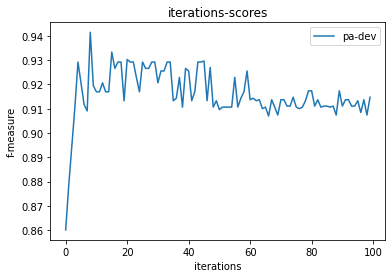

In [ ]:
plt.plot(iter_scores, label='pa-dev')
plt.ylabel('f-measure')
plt.xlabel('iterations')
plt.title('iterations-scores')
plt.legend()
plt.show()

In [ ]:
iter_scores = []
for i in range(1, 101):
      # создаём алгоритм
      crf = sklearn_crfsuite.CRF(
      algorithm='ap', max_iterations = i
      )  
      #открываем тренировочную выборку
      df_train, X_train, y_train =  tsv_to_samples('train.tsv', features, is_train=True, unite_punct=False, type_='letters')
      #обучаем алгоритм
      crf.fit(X_train, y_train)
      #считаем скор
      score = predict_and_score(crf, df_dev, X_dev, name='dev')
      iter_scores.append(score['f-measure'])
      print(i, score)

1 {'precision': 0.8793456032719835, 'recall': 0.8650306748466258, 'f-measure': 0.8706397896581949}
2 {'precision': 0.903885480572597, 'recall': 0.894683026584867, 'f-measure': 0.89845165059889}
3 {'precision': 0.9049079754601227, 'recall': 0.8967280163599182, 'f-measure': 0.9001460706982181}
4 {'precision': 0.903885480572597, 'recall': 0.8957055214723927, 'f-measure': 0.899094361671049}
5 {'precision': 0.8987730061349694, 'recall': 0.8905930470347647, 'f-measure': 0.8940111013730646}
6 {'precision': 0.9028629856850717, 'recall': 0.8967280163599182, 'f-measure': 0.8992696465089104}
7 {'precision': 0.9089979550102248, 'recall': 0.9028629856850715, 'f-measure': 0.9054046158340637}
8 {'precision': 0.911042944785276, 'recall': 0.9059304703476482, 'f-measure': 0.9080338884019866}
9 {'precision': 0.9130879345603271, 'recall': 0.9089979550102248, 'f-measure': 0.9106631609699094}
10 {'precision': 0.8987730061349694, 'recall': 0.8936605316973415, 'f-measure': 0.8957639497516798}
11 {'precision':

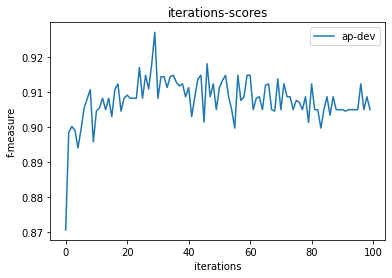

In [ ]:
plt.plot(iter_scores, label='ap-dev')
plt.ylabel('f-measure')
plt.xlabel('iterations')
plt.title('iterations-scores')
plt.legend()
plt.show()

In [ ]:
for states in [True, False]:
  for trans in [True, False]:
      # создаём алгоритм
      crf = sklearn_crfsuite.CRF(
      algorithm='pa', max_iterations=9,
      all_possible_states=states,
      all_possible_transitions=trans
      )  
      #открываем тренировочную выборку
      df_train, X_train, y_train =  tsv_to_samples('train.tsv', features, is_train=True, unite_punct=False, type_='letters')
      #обучаем алгоритм
      crf.fit(X_train, y_train)
      #считаем скор
      score = predict_and_score(crf, df_dev, X_dev, name='dev')
      print('states', states, 'trans', trans, score)

states True trans True {'precision': 0.9304703476482619, 'recall': 0.9284253578732106, 'f-measure': 0.9292433537832311}
states True trans False {'precision': 0.9314928425357872, 'recall': 0.9304703476482615, 'f-measure': 0.9307040607654105}
states False trans True {'precision': 0.9253578732106338, 'recall': 0.9212678936605316, 'f-measure': 0.9229330996202161}
states False trans False {'precision': 0.9100204498977504, 'recall': 0.9069529652351737, 'f-measure': 0.9080338884019866}


In [ ]:
      # создаём алгоритм
      crf = sklearn_crfsuite.CRF(
      algorithm='pa', max_iterations=100,
      all_possible_states=True
      )  
      #открываем тренировочную выборку
      df_train, X_train, y_train =  tsv_to_samples('train.tsv', features, is_train=True, unite_punct=False, type_='letters')
      #обучаем алгоритм
      crf.fit(X_train, y_train)
      #считаем скор
      score = predict_and_score(crf, df_test, X_test, name='test')
      print(score)

{'precision': 0.8931517663311621, 'recall': 0.8934971383461614, 'f-measure': 0.8928867461727149}
